In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path
from dateutil.relativedelta import relativedelta
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Masking
from tensorflow.keras.models import Model
from tqdm.keras import TqdmCallback

import seaborn as sns
from matplotlib import pyplot as plt

2023-08-15 17:56:33.467716: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-15 17:56:33.518261: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-15 17:56:33.519433: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 17:56:34.329346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
zarr_ds = xr.open_zarr(store='/home/jovyan/shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)
zarr_ds

<xarray.Dataset>
Dimensions:          (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -11.5 -11.75 -12.0
  * lon              (lon) float32 42.0 42.25 42.5 42.75 ... 101.5 101.8 102.0
  * time             (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-12-31
Data variables: (12/19)
    CHL              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    curr_dir         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    curr_speed       (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ...               ...
    ug_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_dir         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_speed       (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/17)
    creator_email:              minhphan@uw.edu
    creator_name:               Minh Phan
    creator_type:               person
    date_created:               2023-07-19
    geospatial_lat_max:         32.0
    geospatial_lat_min:         -12.0
    ...                         ...
    geospatial_lon_units:       degrees_east
    source:                     Earth & Space Research (ESR), Copernicus Clim...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    time_coverage_end:          2022-12-31T23:59:59
    time_coverage_start:        1979-01-01T00:00:00
    title:                      Climate Data for Coastal Upwelling Machine Le...

In [3]:
zarr_new = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))

In [4]:
from tensorflow.keras.models import load_model

model_path = '/home/jovyan/shared/jiarui-notebooks/2D_classification_nc.keras'

# Load the model
model = load_model(model_path)

In [5]:
def create_data_map(variable_name, start_date='1979-01-01', end_date='1999-12-31'):
    date_range = pd.date_range(start=start_date, end=end_date)

    zarr_dates = pd.to_datetime(zarr_new.time.values)

    # times we don't have labels
    skip_ranges = [
        pd.date_range(start='1983-04-01', end='1983-04-30'),
        pd.date_range(start='1988-02-01', end='1988-02-29'),  # February in a leap year
        pd.date_range(start='1992-09-01', end='1992-09-30'),
        pd.date_range(start='1997-02-01', end='1997-02-28'),
        pd.date_range(start='2001-11-01', end='2001-11-30'),
        pd.date_range(start='2006-04-01', end='2006-04-30'),
        pd.date_range(start='2011-02-01', end='2011-02-28'),
        pd.date_range(start='2015-06-01', end='2015-06-30'),
        pd.date_range(start='2020-02-01', end='2020-02-29')  # February in a leap year
    ]

    date_to_data_map = {}

    for date in date_range:
        if any(date in skip_range for skip_range in skip_ranges):
            continue
        if date in zarr_dates:
            data = getattr(zarr_new, variable_name).sel(time=str(date.date())).values
            if not np.all(np.isnan(data)):
                mean_val = np.nanmean(data)
                normalized_day_data = data - mean_val
                normalized_day_data = np.nan_to_num(normalized_day_data, nan=0.0)

                date_to_data_map[date] = normalized_day_data

    return date_to_data_map

data_map = create_data_map('sst')

In [6]:
def get_labels(start_date, end_date):
    # Convert input dates to datetime format
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # List to store all group labels
    all_labels = pd.Series(dtype=int)

    # Initialize current date to start_date
    curr_date = start_date

    while curr_date <= end_date:
        year = curr_date.year
        month = curr_date.month

        file_name = f"/home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/{year}{month:02d}_sst_diff.nc"
        if not Path(file_name).exists():
            print(f"File {file_name} does not exist, skipping...")
            curr_date += relativedelta(months=1)
            continue
        print(f"Processing file {file_name}...")

        # Open the dataset and convert it to a pandas DataFrame
        temp = xr.open_dataset(file_name)
        temp_df = temp.to_dataframe()

        # Convert the 'time' column to date only format
        temp_df.index = pd.to_datetime(temp_df.index).date

        # Reset index to create 'time' column
        temp_df = temp_df.reset_index()

        # Create a new column 'entry_id' which enumerates each entry within each date
        temp_df['entry_id'] = temp_df.groupby('time').cumcount()

        # Filter dataframe for rows where 'entry_id' is 22 and 23, and create a copy
        filtered_df = temp_df[temp_df['entry_id'].isin([22,23])].copy()

        # Create a label column - set to 1 if SST_Diff < threshold, else set to 0
        threshold = -1
        filtered_df.loc[:, 'label'] = np.where(filtered_df['SST_Diff'] < threshold, 1, 0)

        # Group by 'time' and check if all 'label' in a group is 1, if so, set group_label to 1, else 0
        group_labels = filtered_df.groupby('time')['label'].apply(lambda x: 1 if x.sum() == 2 else 0)

        # Append the group_labels to all_labels
        all_labels = pd.concat([all_labels, group_labels])

        # Move to the next month
        curr_date += relativedelta(months=1)

    print(all_labels.shape)
    return all_labels

# Call the function with your specific start and end date
labels = get_labels('1979-01-01', '1999-12-31')

Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/197901_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/197902_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/197903_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/197904_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/197905_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/197906_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/197907_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/197908_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/197909_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/197910_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0

In [7]:
valid_dates = list(data_map.keys())
filtered_labels = labels[labels.index.isin(valid_dates)]

assert len(data_map) == len(filtered_labels)

In [8]:
data = []  # List to store each row of the DataFrame

# Iterate through all dates in date_to_data_map
for date, day_data in data_map.items():
    actual_val = filtered_labels[date]
        
    # Pre-process the day data and predict
    day_data = np.nan_to_num(day_data, nan=0.0)  # Replace NaN with 0
    day_data = np.expand_dims(day_data, axis=(0, -1))  # Add a new dimension for the batch and channel

    prediction = model.predict(day_data, verbose=0)

    # Append the data for the current date to the list
    data.append({'time': date, 'actual_val': actual_val, 'predicted_val': prediction[0][0]})

# Create a DataFrame from the data list
df = pd.DataFrame(data)

# Check the DataFrame
print(df)

           time  actual_val  predicted_val
0    1979-01-01           0       0.003156
1    1979-01-02           0       0.003160
2    1979-01-03           0       0.003229
3    1979-01-04           0       0.003305
4    1979-01-05           0       0.003350
...         ...         ...            ...
6716 1999-12-27           0       0.003561
6717 1999-12-28           0       0.003684
6718 1999-12-29           0       0.003569
6719 1999-12-30           0       0.003514
6720 1999-12-31           0       0.003447

[6721 rows x 3 columns]


In [9]:
print(len(df[(df['actual_val'] == 0) & (df['predicted_val'] > 0.5)]))
print(len(df[(df['actual_val'] == 0)]))
print(len(df[(df['actual_val'] == 1) & (df['predicted_val'] > 0.5)]))
print(len(df[(df['actual_val'] == 1)]))

211
6269
421
452


/tmp/ipykernel_44/2030461022.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group0, bins=20, kde=False, norm_hist=True, label='Actual_val 0')
/tmp/ipykernel_44/2030461022.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1, bins=20, kde=False, norm_hist=True, label='Actual_val 1')


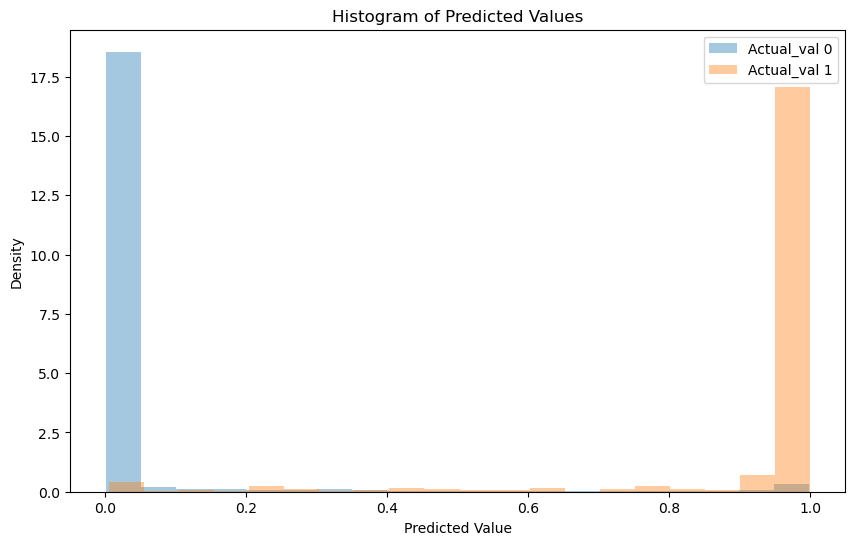

In [10]:
# Convert 'predicted_val' to float
df['predicted_val'] = df['predicted_val'].apply(lambda x: float(x[0]) if isinstance(x, (list, np.ndarray)) else float(x))

# Separate the data into two groups based on 'actual_val'
group0 = df[df['actual_val'] == 0]['predicted_val']
group1 = df[df['actual_val'] == 1]['predicted_val']

# Create the histogram plot
plt.figure(figsize=(10, 6))
sns.distplot(group0, bins=20, kde=False, norm_hist=True, label='Actual_val 0')
sns.distplot(group1, bins=20, kde=False, norm_hist=True, label='Actual_val 1')

# Set the labels and title
plt.xlabel('Predicted Value')
plt.ylabel('Density')
plt.title('Histogram of Predicted Values')
plt.legend()

# Show the plot
plt.show()

/tmp/ipykernel_44/2049830768.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['month'] = filtered_df['time'].dt.month


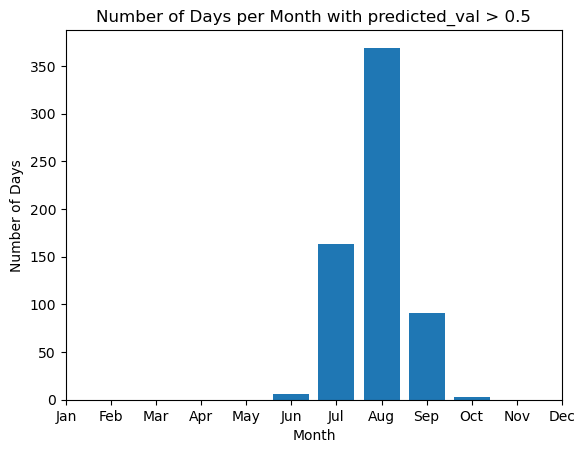

In [11]:
# Filter the DataFrame based on the condition
filtered_df = df[df['predicted_val'] > 0.5]

# Extract the month from the 'time' column
filtered_df['month'] = filtered_df['time'].dt.month

# Count the occurrences for each month
month_counts = filtered_df['month'].value_counts().sort_index()

# Plot the histogram
plt.bar(month_counts.index, month_counts.values)
plt.xlabel('Month')
plt.ylabel('Number of Days')
plt.title('Number of Days per Month with predicted_val > 0.5')
plt.xticks(ticks=range(1,13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

In [12]:
# pip install lime

  Using cached lime-0.2.0.1-py3-none-any.whl
  Using cached scikit_image-0.21.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.8 MB)
  Using cached imageio-2.31.1-py3-none-any.whl (313 kB)
  Using cached PyWavelets-1.4.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.9 MB)
  Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)
Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


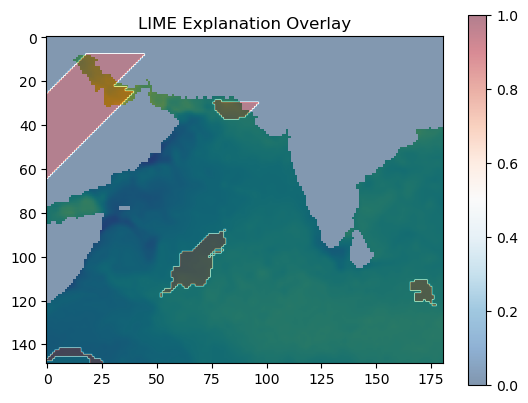

In [20]:
from lime import lime_image
from skimage.segmentation import felzenszwalb
from lime.wrappers.scikit_image import SegmentationAlgorithm

def preprocess_and_predict(image_array, model, target_shape=(149, 181)):
    # Ensure the shape matches target shape
    assert image_array.shape == target_shape, "Data shape mismatch!"
    
    # Normalize the image by subtracting its mean
    mean_val = np.nanmean(image_array)
    normalized_image = image_array - mean_val
 
    # If there are any NaN values, replace them with 0
    normalized_image = np.nan_to_num(normalized_image)
    
    # Adjust dimensions of the image to match model's expected input shape
    preprocessed_image = normalized_image[np.newaxis, :, :, np.newaxis]  # Adds a batch dimension and a channel dimension

    # Use the model to predict upwelling
    prediction = model.predict(preprocessed_image)
    return prediction[0][0]

explainer = lime_image.LimeImageExplainer()
segmenter = SegmentationAlgorithm('felzenszwalb', scale=100, sigma=0.5, min_size=50)

def model_predict(images_list):
    results = []
    for img in images_list:
        grayscale_img = img[:, :, 0]
        pred = preprocess_and_predict(grayscale_img, model)
        results.append([1-pred, pred])
    return np.array(results)

def plot_sample_with_mask(sample, mask, title=''):
    sample_2d = np.squeeze(sample)
    
    plt.imshow(sample_2d, cmap='viridis')
    plt.imshow(mask, alpha=0.5, cmap='RdBu_r')
    
    plt.title(title)
    plt.colorbar()
    plt.show()

npy_path = "/home/jovyan/shared/jiarui-notebooks/2018-07-15.npy"
image_array = np.load(npy_path)
target_shape = (149, 181)

explainer_image = image_array[:, :, np.newaxis]  # Adds a channel dimension
explanation = explainer.explain_instance(explainer_image, model_predict, top_labels=5, hide_color=0, num_samples=1000, segmentation_fn=segmenter)

temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=5, hide_rest=False)
plot_sample_with_mask(explainer_image, mask, title='LIME Explanation Overlay')

  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


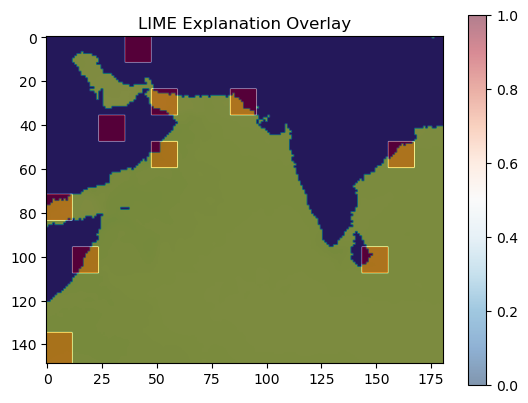

In [22]:
# from lime import lime_image
from skimage.segmentation import felzenszwalb, quickshift, slic
# from lime.wrappers.scikit_image import SegmentationAlgorithm

def preprocess_and_predict(image_array, model, target_shape=(149, 181)):
    assert image_array.shape == target_shape, "Data shape mismatch!"
    
    mean_val = np.nanmean(image_array)
    normalized_image = image_array - mean_val
    normalized_image = np.nan_to_num(normalized_image)
    preprocessed_image = normalized_image[np.newaxis, :, :, np.newaxis] 

    prediction = model.predict(preprocessed_image)
    return prediction[0][0]

explainer = lime_image.LimeImageExplainer()

# Here, let's try 'slic' segmentation method as an example
segmenter = SegmentationAlgorithm('slic', n_segments=200, compactness=10, max_iter=10)

def model_predict(images_list):
    results = []
    for img in images_list:
        grayscale_img = img[:, :, 0]
        pred = preprocess_and_predict(grayscale_img, model)
        results.append([1-pred, pred])
    return np.array(results)

def plot_sample_with_mask(sample, mask, title=''):
    sample_2d = np.squeeze(sample)
    
    plt.imshow(sample_2d, cmap='viridis')
    plt.imshow(mask, alpha=0.5, cmap='RdBu_r')
    
    plt.title(title)
    plt.colorbar()
    plt.show()

npy_path = "/home/jovyan/shared/jiarui-notebooks/2018-07-15.npy"
image_array = np.load(npy_path)
target_shape = (149, 181)

explainer_image = image_array[:, :, np.newaxis] 
explainer_image = np.nan_to_num(explainer_image)
explanation = explainer.explain_instance(explainer_image, model_predict, top_labels=5, hide_color=0, num_samples=5000, segmentation_fn=segmenter)

# Let's try displaying more features, e.g., 10.
temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=10, hide_rest=False)
plot_sample_with_mask(explainer_image, mask, title='LIME Explanation Overlay')


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


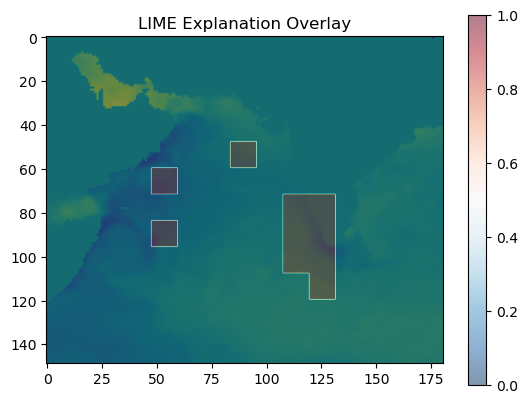

In [23]:
# from lime import lime_image
from skimage.segmentation import felzenszwalb, quickshift, slic
# from lime.wrappers.scikit_image import SegmentationAlgorithm

def preprocess_and_predict(image_array, model, target_shape=(149, 181)):
    assert image_array.shape == target_shape, "Data shape mismatch!"
    
    mean_val = np.nanmean(image_array)
    normalized_image = image_array - mean_val
    normalized_image = np.nan_to_num(normalized_image)
    preprocessed_image = normalized_image[np.newaxis, :, :, np.newaxis] 

    prediction = model.predict(preprocessed_image)
    return prediction[0][0]

explainer = lime_image.LimeImageExplainer()

# Here, let's try 'slic' segmentation method as an example
segmenter = SegmentationAlgorithm('slic', n_segments=200, compactness=10, max_iter=10)

def model_predict(images_list):
    results = []
    for img in images_list:
        grayscale_img = img[:, :, 0]
        pred = preprocess_and_predict(grayscale_img, model)
        results.append([1-pred, pred])
    return np.array(results)

def plot_sample_with_mask(sample, mask, title=''):
    sample_2d = np.squeeze(sample)
    
    plt.imshow(sample_2d, cmap='viridis')
    plt.imshow(mask, alpha=0.5, cmap='RdBu_r')
    
    plt.title(title)
    plt.colorbar()
    plt.show()

npy_path = "/home/jovyan/shared/jiarui-notebooks/2018-07-15.npy"
image_array = np.load(npy_path)
target_shape = (149, 181)

explainer_image = image_array.copy()  
explainer_image = np.nan_to_num(explainer_image - np.nanmean(explainer_image))  # Normalize and remove NaN
explainer_image = explainer_image[:, :, np.newaxis]

explanation = explainer.explain_instance(explainer_image, model_predict, top_labels=5, hide_color=0, num_samples=3000, segmentation_fn=segmenter)

# Let's try displaying more features, e.g., 10.
temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=10, hide_rest=False)
plot_sample_with_mask(explainer_image, mask, title='LIME Explanation Overlay')


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


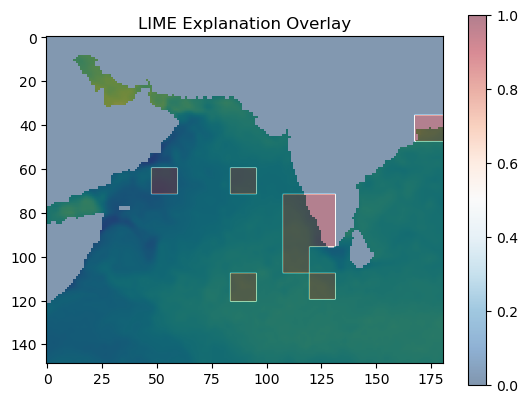

In [24]:
from lime import lime_image
from skimage.segmentation import felzenszwalb, quickshift, slic
from lime.wrappers.scikit_image import SegmentationAlgorithm

def preprocess_and_predict(image_array, model, target_shape=(149, 181)):
    assert image_array.shape == target_shape, "Data shape mismatch!"
    
    mean_val = np.nanmean(image_array)
    normalized_image = image_array - mean_val
    normalized_image = np.nan_to_num(normalized_image)
    preprocessed_image = normalized_image[np.newaxis, :, :, np.newaxis] 

    prediction = model.predict(preprocessed_image)
    return prediction[0][0]

explainer = lime_image.LimeImageExplainer()

segmenter = SegmentationAlgorithm('slic', n_segments=200, compactness=10, max_iter=10)

def model_predict(images_list):
    results = []
    for img in images_list:
        grayscale_img = img[:, :, 0]
        pred = preprocess_and_predict(grayscale_img, model)
        results.append([1-pred, pred])
    return np.array(results)

def plot_sample_with_mask(sample, mask, nan_mask, title=''):
    sample_2d = np.squeeze(sample).copy()
    sample_2d[nan_mask] = np.nan  # Restore NaN values for visualization
    
    plt.imshow(sample_2d, cmap='viridis')
    plt.imshow(mask, alpha=0.5, cmap='RdBu_r')
    
    plt.title(title)
    plt.colorbar()
    plt.show()

npy_path = "/home/jovyan/shared/jiarui-notebooks/2018-07-15.npy"
image_array = np.load(npy_path)
nan_mask = np.isnan(image_array)
target_shape = (149, 181)

explainer_image = image_array.copy()  
explainer_image = np.nan_to_num(explainer_image - np.nanmean(explainer_image))  # Normalize and remove NaN
explainer_image = explainer_image[:, :, np.newaxis]

explanation = explainer.explain_instance(explainer_image, model_predict, top_labels=5, hide_color=0, num_samples=3000, segmentation_fn=segmenter)

temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=10, hide_rest=False)
plot_sample_with_mask(explainer_image, mask, nan_mask, title='LIME Explanation Overlay')

In [44]:
pip install protobuf==3.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.8 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.13.0 requires protobuf>=3.19.6, but you have protobuf 3.15.0 which is incompatible.
tensorflow 2.13.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.15.0 which is incompatible.
tensorflow-hub 0.14.0 requires protobuf>=3.19.6, but you have protobuf 3.15.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [45]:
# This chunk is for coreml conversion
import coremltools as ct

coreml_model = ct.convert(model)

coreml_model.save('upwelling_classification.mlmodel')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_44/3476794569.py", line 2, in <module>
    import coremltools as ct
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/coremltools/__init__.py", line 54, in <module>
    from . import converters
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/coremltools/converters/__init__.py", line 7, in <module>
    from . import libsvm
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/coremltools/converters/libsvm/__init__.py", line 8, in <module>
    from . import _libsvm_converter
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/coremltools/converters/libsvm/_libsvm_converter.py", line 9, in <module>
    from coremltools.models import _METADATA_VERSION, _METADATA_SOURCE
  File "/srv/conda/envs/notebook/lib/python3.9/site-pac

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 149, 181, 1)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 149, 181, 1)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 149, 181, 1)          3         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv_pad (ZeroPadding  (None, 151, 183, 1)          0         ['normalization[0][0]']   

In [39]:
from tensorflow import keras
import coremltools as ct

model2 = keras.models.load_model('/home/jovyan/LSTM_direction_199709_202012.h5')

# Convert the model to CoreML
coreml_model = ct.converters.keras.convert(model2)

# Save the CoreML model
coreml_model.save('model.mlmodel')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_44/1492007957.py", line 2, in <module>
    import coremltools as ct
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/coremltools/__init__.py", line 54, in <module>
    from . import converters
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/coremltools/converters/__init__.py", line 7, in <module>
    from . import libsvm
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/coremltools/converters/libsvm/__init__.py", line 8, in <module>
    from . import _libsvm_converter
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/coremltools/converters/libsvm/_libsvm_converter.py", line 9, in <module>
    from coremltools.models import _METADATA_VERSION, _METADATA_SOURCE
  File "/srv/conda/envs/notebook/lib/python3.9/site-pac

In [46]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('upwelling_detection.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpvgz5p5qt/assets


INFO:tensorflow:Assets written to: /tmp/tmpvgz5p5qt/assets
2023-08-15 21:59:40.212238: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-15 21:59:40.212291: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-15 21:59:40.213309: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvgz5p5qt
2023-08-15 21:59:40.253048: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-08-15 21:59:40.253102: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpvgz5p5qt
2023-08-15 21:59:40.345199: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-08-15 21:59:40.388371: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-15 21:59:41.638833: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio